# SXSW Tweets: Sentiment Analysis using NLP


**Authors**: Marcelo Scatena, Czarina Luna, Piotr Czolpik, Ross McKim

***
February 2022

<img src='images/header.jpeg' align='left'/>

[Image Source](https://www.hackreactor.com/blog/software-engineers-guide-to-sxsw-2021)

# Table of Contents
* [Summary](#Summary)
* [Business Problem](#Business_Problem)
* [Data Understanding](#Data_Understanding)
* [I. Data Exploration](#Data_Exploration)
* [II. Data Modeling](#Data_Modeling)    
    * [Baseline Model](#Baseline_Model)
    * [Machine Learning Pipeline](#Pipeline)
    * [Hyperparameter Tuning](#Hyperparameter_Tuning)
* [III. Final Model](#Final_Model)
* [IV. Results](#Results)
* [V. Recommendations](#Recommendations)
* [Next Steps](#Next_Steps)
* [Contact Us](#Contact)

# Summary <a class="anchor" id="Summary"></a>
We are digital brand advisors that have been hired by South by Southwest. Our goal is to perform sentiment analysis on twitter sentiment regarding the 2011 SXSW festival. In 2011 Apple released the Ipad 2 at the SXSW festival which makes this an ideal situation for analyzing first impressions of a small group of people.

# Business Problem <a class="anchor" id="Business_problem"></a>
We are examining how effectively we can measure sentiment during such an event. To accomplish this task we used a Machine Learning model that uses Natural Language Processing and distinguishes between positive, negative, or neutral sentiment in a tweet. The focus though is on being able to classify the highest amount of Negative sentiments, since they are the ones that may influence others that are still undecided on purchasing a product, without reducing much the number of positive sentiment tweets that the model correctly predicts.

# Data Understanding <a class="anchor" id="Data_Understanding"></a>
The information we have is regarding the 2011 South by Southwest festival that introduced the Ipad2. It is in data.world. It contains over 9,000 tweets from users talking about the festival and it's products, and the sentiment of the tweet has been categorized by it being either positive, negative, neutral or unable to tell. There is a big imbalance of results in that regard, and another one when taking into consideration which products those sentiments are regarding.

# I. Data Exploration <a class="anchor" id="Data_Exploration"></a>
Importing the database:

In [1]:
import pandas as pd

raw_data = pd.read_csv('./data/tweets.csv', encoding='latin1')
raw_data.head(2)

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion


In [2]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


##### Renaming features:

In [3]:
raw_data.columns = ['text', 'product', 'target']

In [4]:
raw_data.isnull().sum()

text          1
product    5802
target        0
dtype: int64

In [5]:
raw_data.duplicated().sum()

22

##### Dropping duplicates and rows with empty information:

In [6]:
raw_data = raw_data.dropna(subset=['text']).drop_duplicates(subset=['text'])

In [7]:
raw_data['product'].value_counts(normalize=True)

iPad                               0.287500
Apple                              0.200915
iPad or iPhone App                 0.142988
Google                             0.130488
iPhone                             0.090244
Other Google product or service    0.089329
Android App                        0.024390
Android                            0.023476
Other Apple product or service     0.010671
Name: product, dtype: float64

In [8]:
raw_data['target'].value_counts(normalize=True)

No emotion toward brand or product    0.592609
Positive emotion                      0.327413
Negative emotion                      0.062769
I can't tell                          0.017209
Name: target, dtype: float64

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

##### Visualizing class balance:

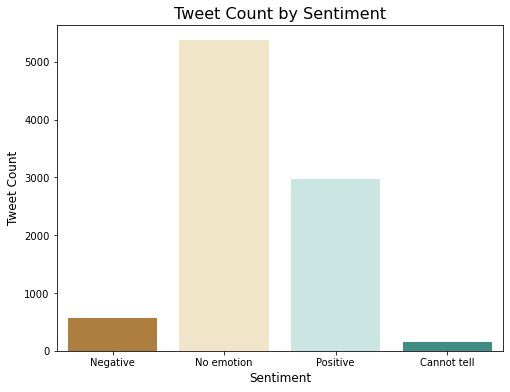

In [10]:
fig, ax = plt.subplots(figsize=(8, 6))
ax = sns.countplot(x='target', data=raw_data, palette='BrBG', order=['Negative emotion', 'No emotion toward brand or product', 'Positive emotion', "I can't tell"])
ax.set_title('Tweet Count by Sentiment', fontsize=16)
ax.set_xlabel('Sentiment', fontsize=12)
ax.set_xticklabels(['Negative', 'No emotion', 'Positive', 'Cannot tell'])
ax.set_ylabel('Tweet Count', fontsize=12)
plt.show()
# sns.color_palette(['#e7404a', '#29b874', '#f5cb39', '#4950ba'])

We can see here a very clear class imbalance. Tweets labeled No Emotion are nearly ten times more often than negative ones, and almost twice as much as the Positive ones. 

In [11]:
raw_data = raw_data.drop((raw_data.loc[raw_data['target']=="I can't tell"]).index)

In [12]:
apple_products = ['iPad', 'Apple', 'iPad or iPhone App', 'iPhone', 'Other Apple product or service']
google_products = ['Google', 'Other Google product or service', 'Android App', 'Android']

raw_data['brand'] = raw_data['product'].apply(lambda x: 'google' if x in google_products else ('apple' if x in apple_products else 'unknown'))

In [13]:
pd.DataFrame(raw_data.groupby(['brand', 'target'])['text'].count())

text
brand   target                                  
apple   Negative emotion                     387
        No emotion toward brand or product    65
        Positive emotion                    1943
google  Negative emotion                     131
        No emotion toward brand or product    26
        Positive emotion                     719
unknown Negative emotion                      51
        No emotion toward brand or product  5281
        Positive emotion                     306

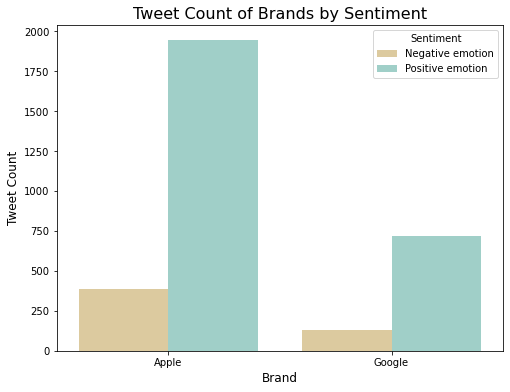

In [14]:
brand_only = raw_data.loc[(raw_data['brand']!='unknown') & (raw_data['target']!='No emotion toward brand or product')]

fig, ax = plt.subplots(figsize=(8, 6))
ax = sns.countplot(x='brand', data=brand_only, hue='target', palette='BrBG')
ax.set_title('Tweet Count of Brands by Sentiment', fontsize=16)
ax.set_xlabel('Brand', fontsize=12)
ax.set_xticklabels(['Apple', 'Google'])
ax.set_ylabel('Tweet Count', fontsize=12)
ax.legend(['Negative', 'Positive'])
plt.legend(title='Sentiment')
plt.show()

There are a lot more comments towards Apple than towards Google, though Unknown is the majority. Both Apple and Google have much more Positive comments than Negative, which should make accurately predicting Negative ones a challenging task.

In [15]:
target_values = {'No emotion toward brand or product':1, 'Positive emotion':2, 'Negative emotion':0}

raw_data['target'] = raw_data['target'].map(target_values)

In [16]:
raw_data['words'] = raw_data['text'].apply(lambda x: len(x.split()))
raw_data['char'] = raw_data['text'].apply(lambda x: len(x))

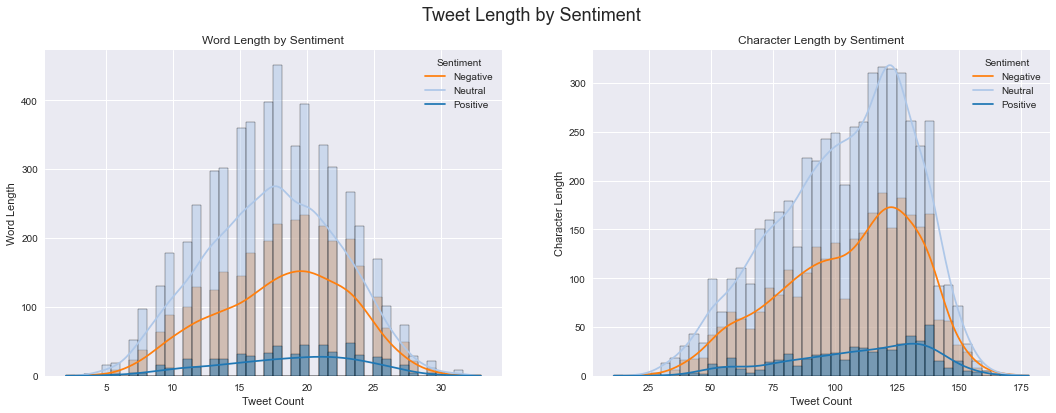

In [17]:
plt.style.use('seaborn')

fig, axes = plt.subplots(ncols=2, figsize=(18, 6))
fig.suptitle('Tweet Length by Sentiment', fontsize=18)

sns.histplot(x='words', data=raw_data, bins='auto', kde=True, hue='target', legend=True, ax=axes[0], palette='tab20')
axes[0].set_title('Word Length by Sentiment')
axes[0].set_xlabel('Tweet Count')
axes[0].set_ylabel('Word Length')
axes[0].legend(['Negative', 'Neutral', 'Positive'], title='Sentiment')

sns.histplot(x='char', data=raw_data, bins='auto', kde=True, hue='target', legend=True, ax=axes[1], palette='tab20')
axes[1].set_title('Character Length by Sentiment')
axes[1].set_xlabel('Tweet Count')
axes[1].set_ylabel('Character Length')
axes[1].legend(['Negative', 'Neutral', 'Positive'], title='Sentiment')

plt.show()

Both graphs here shows distributions that approaches a normal one.

## Train Test Split

In [18]:
from sklearn.model_selection import train_test_split
X = raw_data['text']
y = raw_data['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=112221, stratify=y)

In [19]:
%store y_train

Stored 'y_train' (Series)


In [20]:
%store y_test

Stored 'y_test' (Series)


In [21]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(stop_words='english')

raw_words = cv.fit_transform(X_train)
raw_sum = raw_words.sum(axis=0)

raw_freq = [(word.title(), raw_sum[0, i]) for word, i in cv.vocabulary_.items()]
raw_freq = sorted(raw_freq, key=lambda x: x[1], reverse=True)
words_freq = pd.DataFrame(raw_freq, columns=['word', 'frequency'])

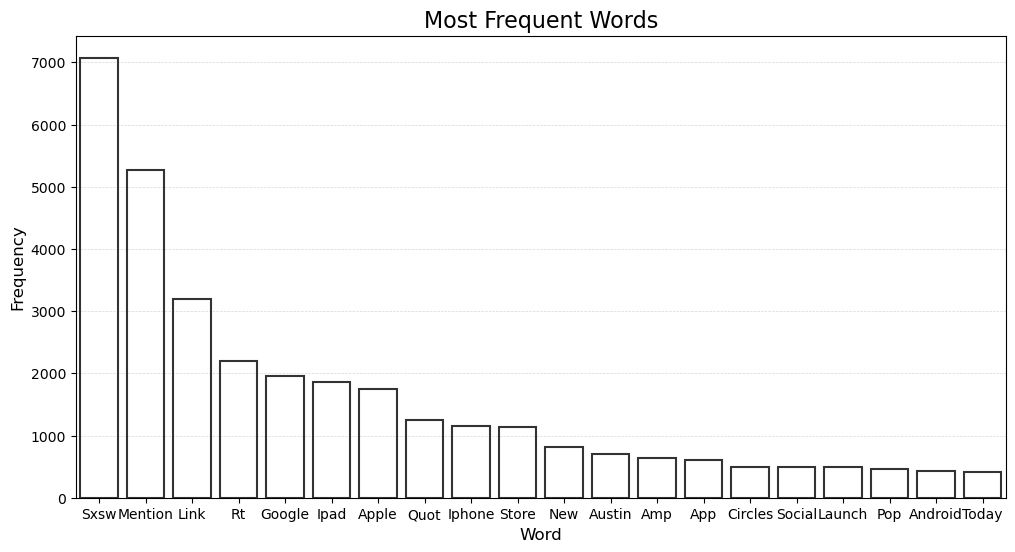

In [22]:
plt.style.use('default')

fig, ax = plt.subplots(figsize=(12, 6))
ax = sns.barplot(x='word', y='frequency', data=words_freq.head(20), linewidth=1.5, facecolor=(1, 1, 1, 0), errcolor=".2", edgecolor=".2", zorder=3)
ax.set_title('Most Frequent Words', fontsize=16)
ax.set_xlabel('Word', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
plt.grid(axis='y', linestyle = '--', linewidth = 0.5, alpha=.5, zorder=0)

We can see both by the graph chart on top and the word cloud beneath that the data has a lot words that are not useful for predicting sentiment. Given the nature of Natural Language Processing, in a twitter dataset, we should treats those words as stopwords.

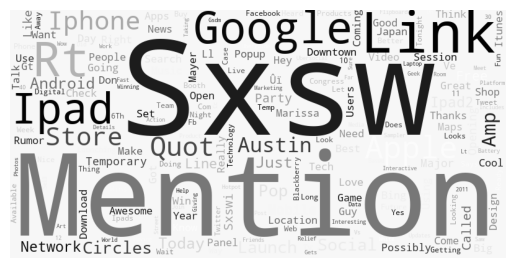

In [23]:
from wordcloud import WordCloud

raw_wordcloud = WordCloud(background_color='#f7f7f7', width=800, height=400, colormap='Greys_r', random_state=1).generate_from_frequencies(dict(raw_freq))

plt.figure()
plt.imshow(raw_wordcloud)
#plt.title('SXSW Tweets Word Cloud')
plt.axis('off')
plt.show()

In [24]:
train_sample = pd.DataFrame(X_train.sample(5, random_state=112221))
train_sample['label'] = [y_train[val] for val in train_sample.index]
train_sample

,text,label
5758,RT @mention Funny that even CNN is saying to s...,1
7358,Vinh: Flipboard is a step forward for iPad mag...,2
6306,RT @mention Mayer: 20% of Google searches are ...,1
4092,&quot;Apple is the most elegant fascist compan...,0
2369,It's official! I'm buying an iPad. #SXSW #elevate,2


## Data Cleaning

In [25]:
import regex as re
import string
import nltk
from nltk.stem.wordnet import WordNetLemmatizer

stopwords = nltk.corpus.stopwords.words('english')
stopwords.extend(['sxsw','sxswi', 'link', 'quot', 'rt'])

lemmatizer = nltk.stem.WordNetLemmatizer()

def preprocess(text):
    '''
    Input: Data series with text string
    Otput: Cleaned data series
    ---
    Steps applied: Lower casing, remove non-english words, remove urls and tagging,
    tokenize, remove punctuation, remove stopwords and perform lemmatization.
    '''
    text = text.apply(lambda x: x.lower()).str.encode('ascii', 'ignore').str.decode('ascii')
    text = text.apply(lambda x: re.sub(r'http\S+', '', x)).apply(lambda x: re.sub(r'@\S*', '', x))

    text = text.apply(lambda x: re.split('\W+', x))
    text = text.apply(lambda x: [''.join(letter for letter in word if letter not in string.punctuation) for word in x])
    text = text.apply(lambda x: [word for word in x if word not in stopwords])
     
    return text.apply(lambda x: [lemmatizer.lemmatize(word) for word in x]).apply(lambda x: ' '.join(x))

In [26]:
train_sample['text'] = preprocess(train_sample['text'])
train_sample

,text,label
5758,funny even cnn saying stay clear austin apple ...,1
7358,vinh flipboard step forward ipad mag get right...,2
6306,mayer 20 google search local information pr,1
4092,apple elegant fascist company america flipboard,0
2369,official buying ipad elevate,2


## Transforming Data

In [27]:
X_train_processed = preprocess(X_train)
X_test_processed = preprocess(X_test)

In [28]:
%store X_train_processed

Stored 'X_train_processed' (Series)


In [29]:
%store X_test_processed

Stored 'X_test_processed' (Series)


In [30]:
processed_words = cv.fit_transform(X_train_processed)
processed_sum = processed_words.sum(axis=0)

processed_freq = [(word.title(), processed_sum[0, i]) for word, i in cv.vocabulary_.items()]
processed_freq = sorted(processed_freq, key=lambda x: x[1], reverse=True)
processed_words_freq = pd.DataFrame(processed_freq, columns=['word', 'frequency'])

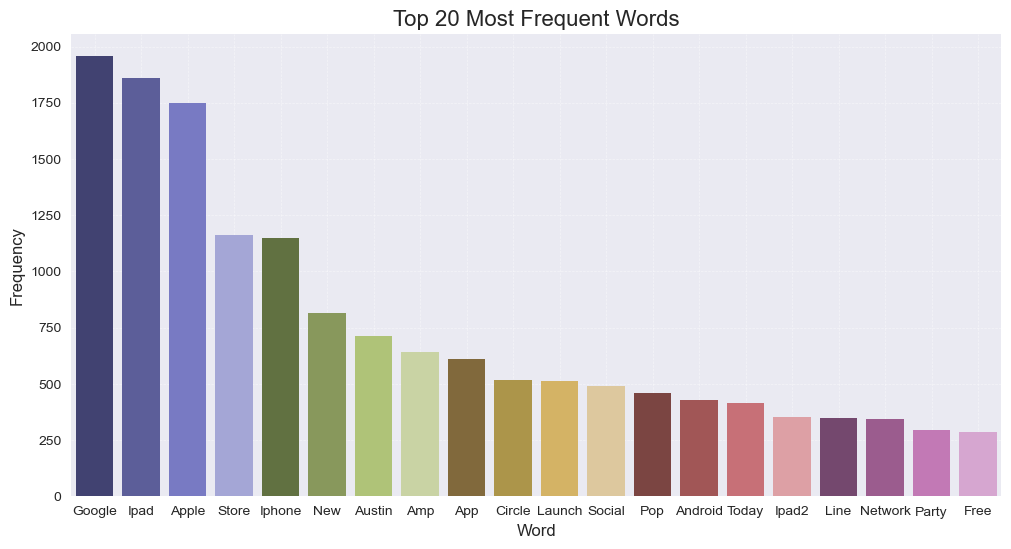

In [31]:
plt.style.use('seaborn')

fig, ax = plt.subplots(figsize=(12, 6))
ax = sns.barplot(x='word', y='frequency', data=processed_words_freq.head(20), palette='tab20b', zorder=3)
ax.set_title('Top 20 Most Frequent Words', fontsize=16)
ax.set_xlabel('Word', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
plt.grid(linestyle = '--', linewidth = 0.5, alpha=.5, zorder=0)

We can see the change of most common words after the data cleaning. There are still a lot of words that might not lead to predicting sentiment, and we can try to find them using wordclouds. If they're equally common in both positive and negative clouds, then they're not useful for predicting sentiment.

In [32]:
train_set_processed = pd.concat([X_train_processed, y_train], axis=1)

In [33]:
from nltk.tokenize import RegexpTokenizer
regex_token = RegexpTokenizer(r'\w+')

sentiment_dict = {}
for idx, name in enumerate(['negative_target', 'neutral_target', 'positive_target']):
    sentiment_text = train_set_processed['text'].loc[train_set_processed['target']==idx].tolist()
    sentiment_data = ' '.join(sentiment_text)
    sentiment_dict[name] = set(regex_token.tokenize(sentiment_data))

In [34]:
str_negative = ' '.join(sentiment_dict['negative_target'])
str_neutral = ' '.join(sentiment_dict['neutral_target'])
str_positive = ' '.join(sentiment_dict['positive_target'])

# unique_negative = ' '.join(A-(B|C))
# unique_neutral = ' '.join(B-(A|C))
# unique_positive = ' '.join(C-(A|B))

In [35]:
from PIL import Image
import numpy as np

In [36]:
def create_wordcloud(str_sentiment, filename, color, bg_color='black', contour_color=None, contour_width=0, random_state=1):
    mask = np.array(Image.open(f'images/{filename}'))
    
    wc = WordCloud(max_font_size=175, width=1000, height=1000, mask=mask, max_words=125, colormap=color, 
                   background_color=bg_color, contour_color=contour_color, contour_width=contour_width,
                   random_state=random_state).generate(str_sentiment)

    plt.figure(figsize=(12,12))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.show()

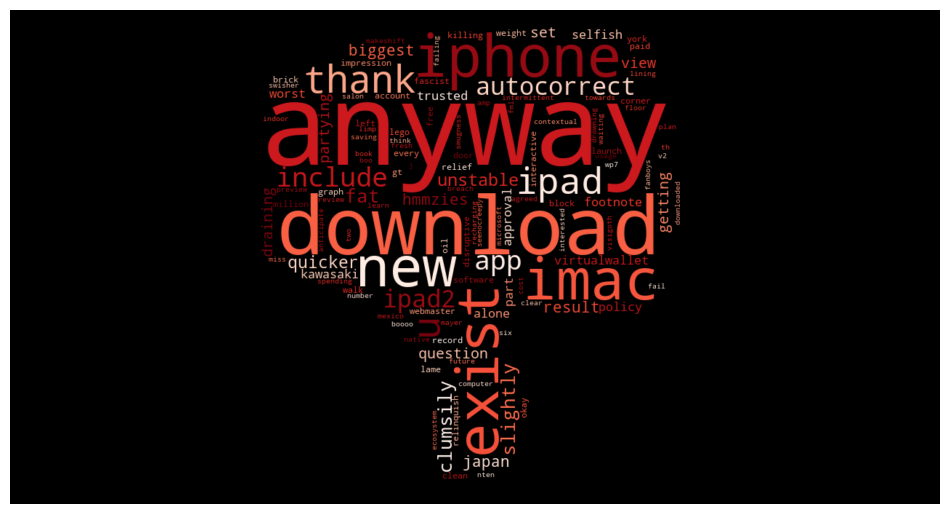

In [37]:
#create_wordcloud(str_negative, 'negative.jpeg', 'Reds_r', 'white', 'darkred', 50)
create_wordcloud(str_negative, 'negative.jpeg', 'Reds_r', 'black')

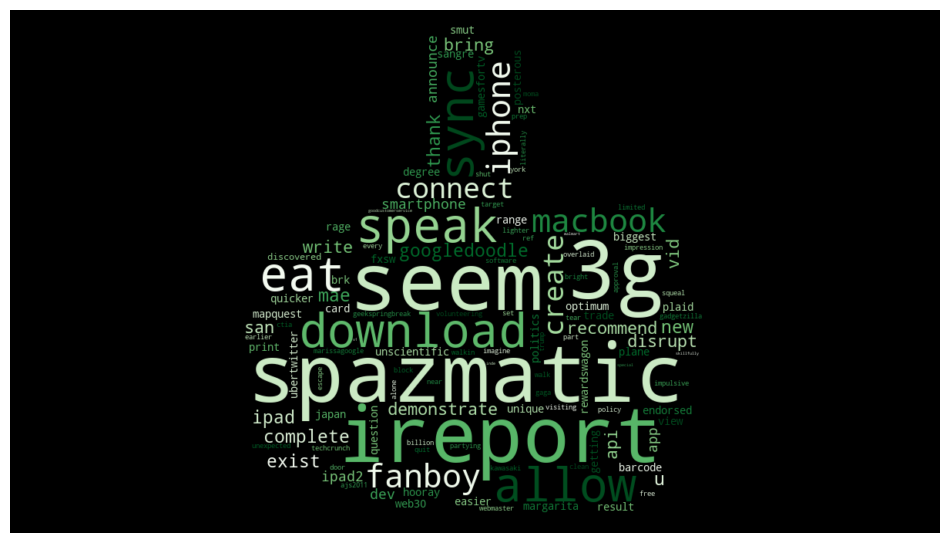

In [38]:
#create_wordcloud(str_positive, 'positive.jpeg', 'Greens_r', 'white', 'darkgreen', 50)
create_wordcloud(str_positive, 'positive.jpeg', 'Greens_r', 'black')

In [39]:
brand_dict = {}
for brand in ['apple', 'google']:
    brand_text = train_set_processed['text'].loc[raw_data.loc[X_train_processed.index,'brand']==brand].tolist()
    brand_data = ' '.join(brand_text)
    brand_dict[brand] = set(regex_token.tokenize(brand_data))
    
str_apple = ' '.join(brand_dict['apple'])
str_google = ' '.join(brand_dict['google'])

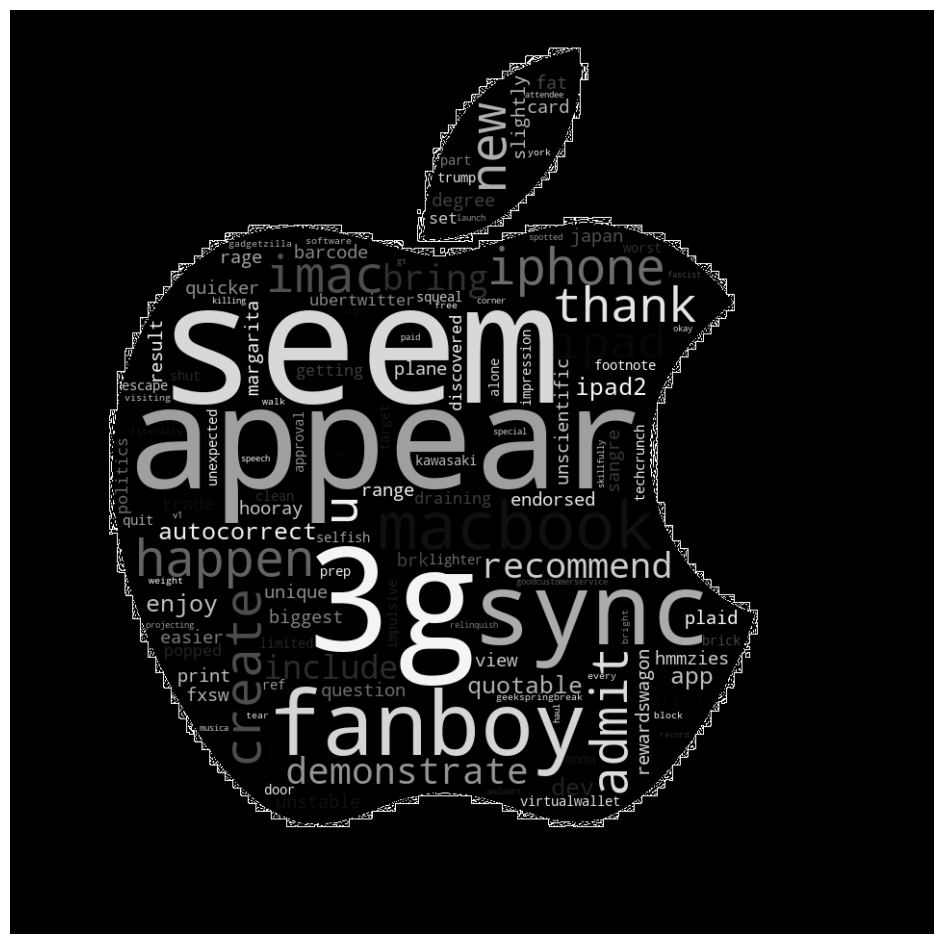

In [55]:
#create_wordcloud(str_apple, 'apple.jpeg', 'Greys_r', 'white', 'black', 15)
create_wordcloud(str_apple, 'apple.jpeg', 'Greys', 'black', 'white', .1)

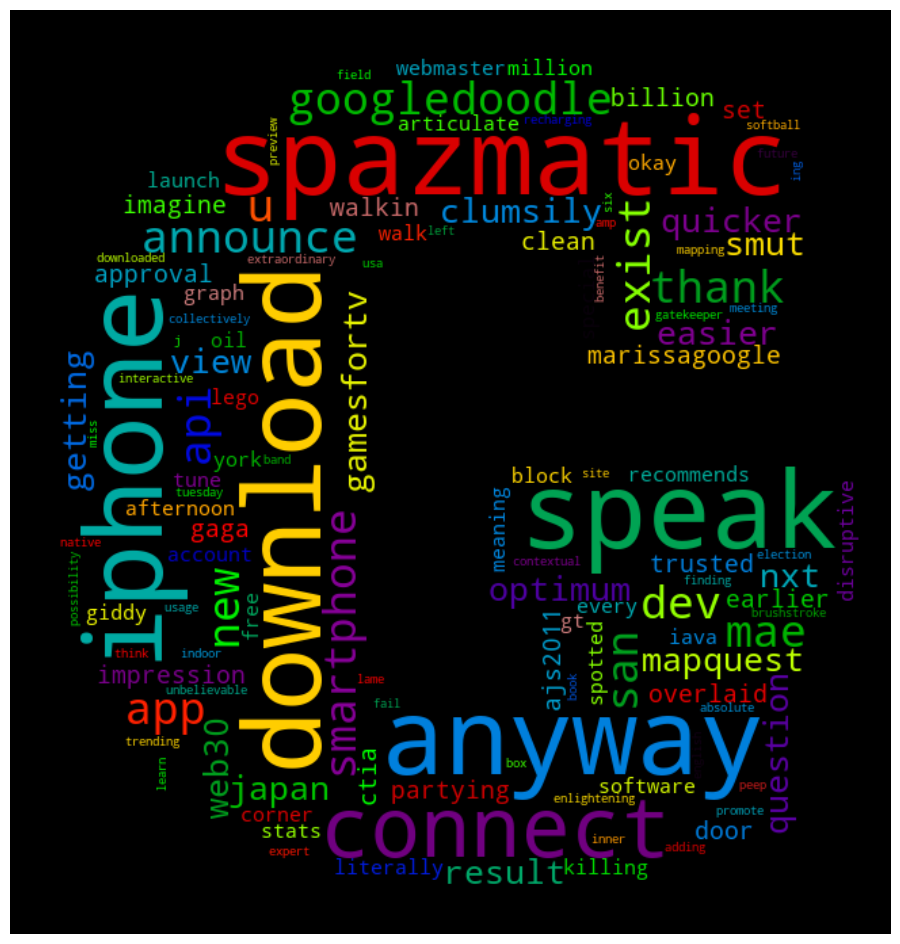

In [56]:
create_wordcloud(str_google, 'google.jpeg', 'nipy_spectral_r', random_state=2)

##### Create bag of words with words that only appear regarding Apple and have a positive sentiment

In [104]:
def remove_stopwords_row(text):
    '''
    Input: Text series
    Output: Text series without new stoprowds
    '''
    ml = text.split()
    less_words = [word for word in ml if word not in even_more_sw]
    ''.join(less_words)
    return less_words

In [100]:
even_more_sw = ['sxsw', 'link', 'apple', 'people', 'one', 'year', 'ipad', 'google', 'store', 'quot', 'iphone', 'austin', 'app', 'ipad2', 'android', 'pop', 'amp', 'new', 'line', 'day', 'time', 'today', 'launch', 'major', 'title', 'via', 'network', 'called', 'u', 'v', 'say', 'see']

In [108]:
apple_data = train_set_processed.loc[raw_data.loc[X_train_processed.index,'brand']=='apple']
apple_data_good = apple_data[apple_data['target']==2]
good_str_apple = ''
for row in apple_data_good['text']:
    good_str_apple += row
apple_less_words_good = remove_stopwords_row(good_str_apple)
apple_less_words_string_good = ' '.join(apple_less_words_good)

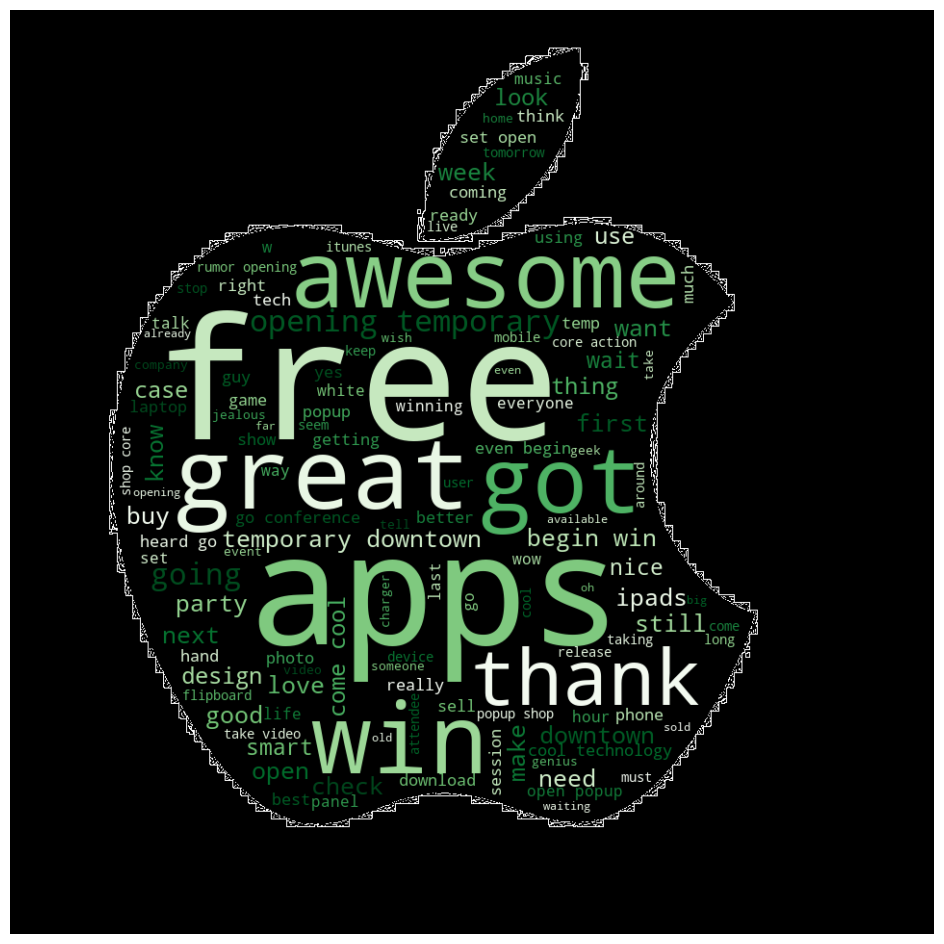

In [109]:
#create_wordcloud(str_apple, 'apple.jpeg', 'Greys_r', 'white', 'black', 15)
create_wordcloud(apple_less_words_string_good, 'apple.jpeg', 'Greens', 'black', 'white', .1)

##### Create bag of words with words that only appear regarding Apple and have a negative sentiment

In [ ]:
apple_data = train_set_processed.loc[raw_data.loc[X_train_processed.index,'brand']=='apple']
apple_data_bad = apple_data[apple_data['target']==0]
bad_str_apple = ''
for row in apple_data_bad['text']:
    bad_str_apple += row
apple_less_words_bad = remove_stopwords_row(bad_str_apple)
apple_less_words_string_bad = ' '.join(apple_less_words_bad)

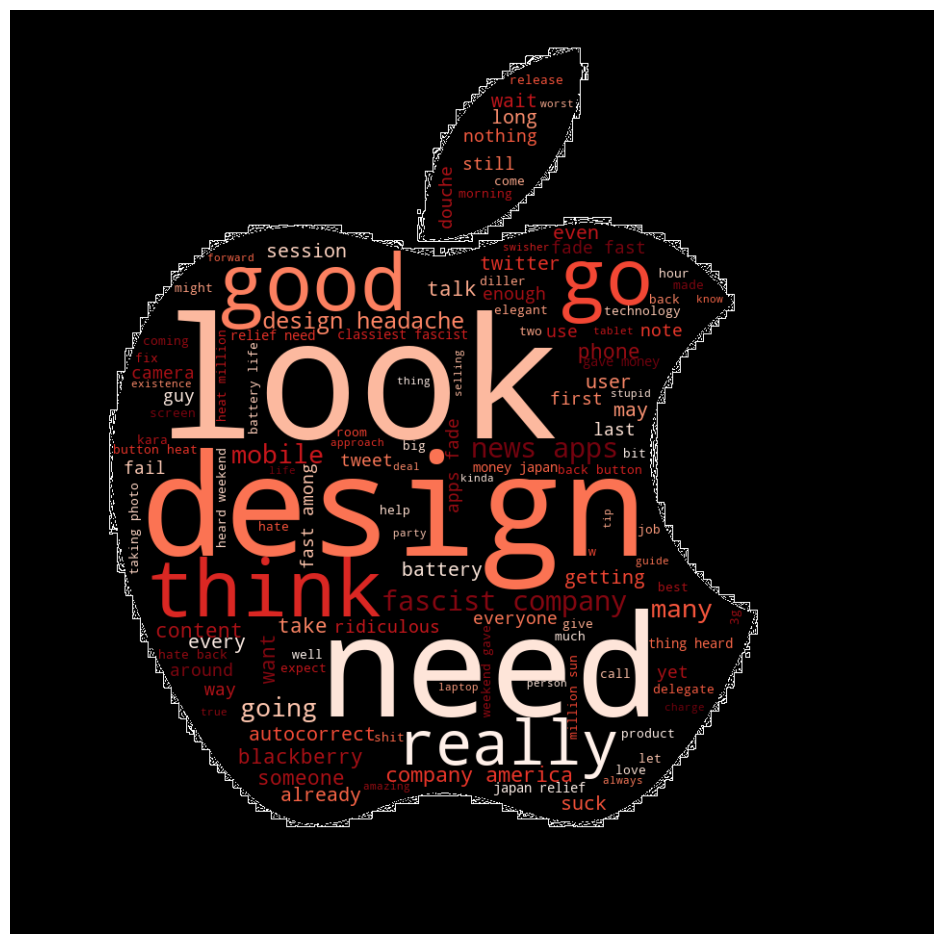

In [110]:
#create_wordcloud(str_apple, 'apple.jpeg', 'Greys_r', 'white', 'black', 15)
create_wordcloud(apple_less_words_string_bad, 'apple.jpeg', 'Reds', 'black', 'white', .1)

##### Create bag of words with words that only appear regarding Google and have a positive sentiment

In [111]:
google_data = train_set_processed.loc[raw_data.loc[X_train_processed.index,'brand']=='google']
google_data_good = google_data[google_data['target']==2]
good_str_google = ''
for row in google_data_good['text']:
    good_str_google += row
google_less_words_good = remove_stopwords_row(good_str_google)
google_less_words_string_good = ' '.join(google_less_words_good)

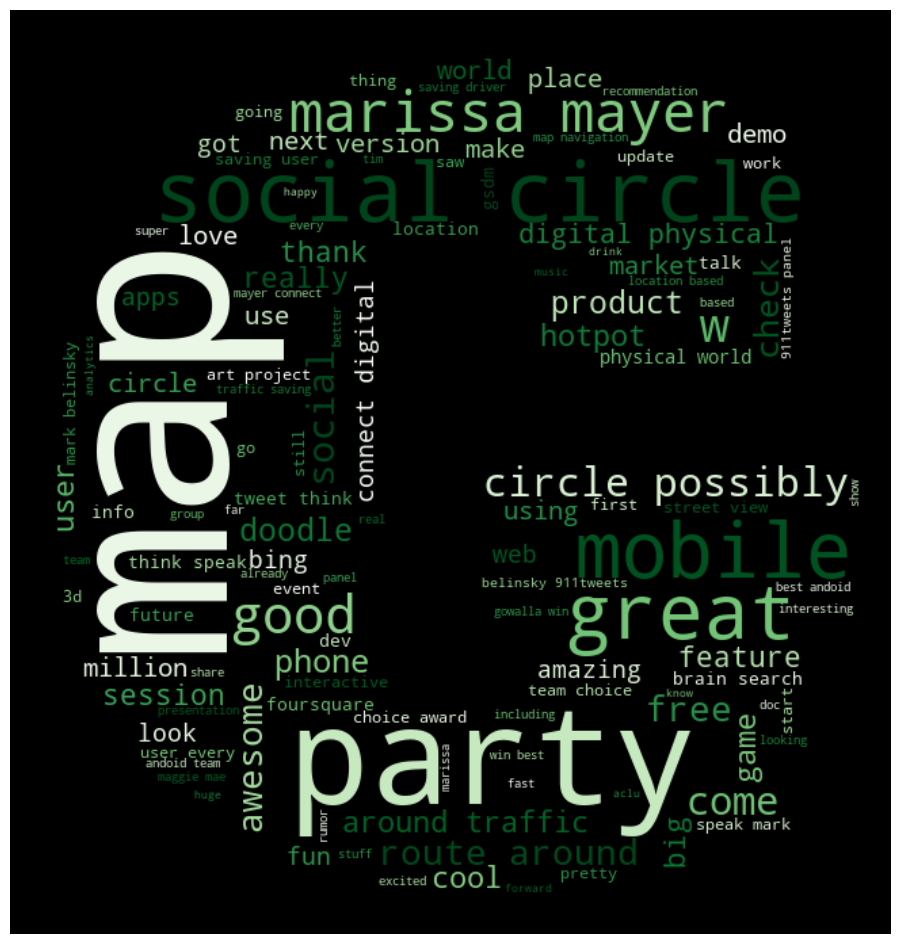

In [112]:
create_wordcloud(google_less_words_string_good, 'google.jpeg', 'Greens', random_state=2)

##### Create bag of words with words that only appear regarding Google and have a negative sentiment

In [113]:
google_data = train_set_processed.loc[raw_data.loc[X_train_processed.index,'brand']=='google']
google_data_bad = google_data[google_data['target']==0]
bad_str_google = ''
for row in google_data_bad['text']:
    bad_str_google += row
google_less_words_bad = remove_stopwords_row(bad_str_google)
google_less_words_string_bad = ' '.join(google_less_words_bad)

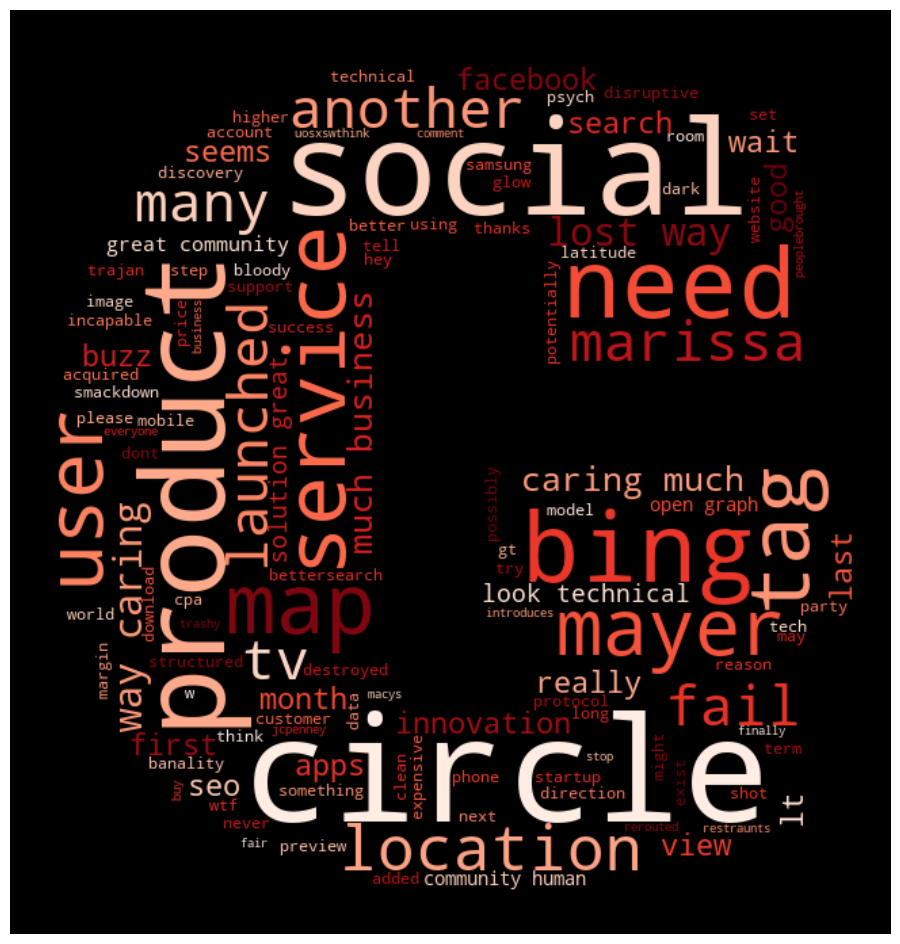

In [114]:
create_wordcloud(google_less_words_string_bad, 'google.jpeg', 'Reds', random_state=2)

## Word2Vec

In [57]:
from gensim.models import Word2Vec
from nltk import word_tokenize

ValueError: numpy.ndarray size changed, may indicate binary incompatibility. Expected 88 from C header, got 80 from PyObject

In [ ]:
X_train_w2v = X_train_processed.map(word_tokenize)

w2v_model = Word2Vec(X_train_w2v, window=5, min_count=1, workers=4)
w2v_model.train(X_train_w2v, total_examples=w2v_model.corpus_count, epochs=w2v_model.epochs)

wv = w2v_model.wv

def show_most_similar(word, length=10):
    return wv.most_similar(word, topn=length)

## Examine Word Vectors

In [ ]:
show_most_similar('apple')

In [ ]:
show_most_similar('google', 5)

In [ ]:
show_most_similar('iphone', 5)

In [ ]:
show_most_similar('android', 5)

In [ ]:
show_most_similar('ipad')

In [ ]:
from nltk.collocations import * # ?
from nltk import TweetTokenizer

tweet_tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True)

X_train_twt = tweet_tokenizer.tokenize(' '.join(X_train_w2v.apply(lambda x: ' '.join(x))))

In [ ]:
bigram_measures = nltk.collocations.BigramAssocMeasures()

finder = BigramCollocationFinder.from_words(X_train_twt)
bigrams = finder.score_ngrams(bigram_measures.raw_freq)

In [ ]:
bigrams[:50]

# II. Data Modeling <a class="anchor" id="Data_Modeling"></a>
The

## Baseline Model <a class="anchor" id="Baseline_Model"></a>

## Pipeline <a class="anchor" id="Pipeline"></a>

In [ ]:
from imblearn.over_sampling import RandomOverSampler
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImPipeline
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [ ]:
ros = RandomOverSampler(random_state=112221)
cv = CountVectorizer(lowercase=False)
tfidf = TfidfVectorizer(stop_words='english', lowercase=False)

def run_model(dict_model, type_, vectorizer, rosample=False):
    X = raw_data['text']
    y = raw_data['target']
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=112221, stratify=y)
    
    X_train = preprocess(X_train)
    X_test = preprocess(X_test)
    
    metric_table = pd.DataFrame(columns=['Model', 'CV Score', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'Type'])

    for name, model in dict_model.items():
        print(f'Running... {name} Model:')
        if rosample:
            ros.fit_resample(np.array(X_train).reshape(-1, 1), y_train)
        else:
            continue
        pipeline = Pipeline(steps=[(str(vectorizer), vectorizer), ('classifier', model['classifier'])])
        pipeline.fit(X_train, y_train)
            
        y_pred = pipeline.predict(X_test)
        y_score = pipeline.predict_proba(X_test)[:,1] 

        cv_score = cross_val_score(pipeline, X_train, y_train, cv=3)
        cv_score_mean = round(np.mean(cv_score), 4)
        
        accuracy, precision, recall, f1 = accuracy_score(y_test, y_pred), precision_score(y_test, y_pred, average='micro'), recall_score(y_test, y_pred, average='micro'), f1_score(y_test, y_pred, average='micro')
        
        metric_table = metric_table.append({'Model': name, 'CV Score': cv_score_mean, 'Accuracy': round(accuracy, 4), 'Precision': round(precision, 4), 
                                            'Recall': round(recall, 4), 'F1 Score': round(f1, 4), 'Type': type_}, ignore_index=True)
        
        print(f'Cross Validation Score: {metric_table.iloc[-1,1]}')
        print(f'Test Accuracy Score: {metric_table.iloc[-1,2]}\n')
    
    return metric_table

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier

In [ ]:
baseline_models = {'LogisticRegression': {'classifier': LogisticRegression(max_iter=1000, random_state=20211122)}, 
                   'MultinomialNB': {'classifier': MultinomialNB()},
                   'DecisionTree': {'classifier': DecisionTreeClassifier(random_state=20211122)},
                   'RandomForest': {'classifier': RandomForestClassifier(random_state=20211122)},
                   'ExtraTrees': {'classifier': ExtraTreesClassifier(random_state=20211122)},
                   'GradientBoost': {'classifier': GradientBoostingClassifier(random_state=20211122)}
                  }

In [ ]:
baseline_cv_table = run_model(baseline_models, 'CV Baseline', cv)
baseline_cv_table

In [ ]:
baseline_cv_ros_table = run_model(baseline_models, 'CV Baseline ROS', cv, rosample=True)
baseline_cv_ros_table

In [ ]:
baseline_tfidf_table = run_model(baseline_models, 'TFIDF Baseline', tfidf)
baseline_tfidf_table

In [ ]:
baseline_tfidf_ros_table = run_model(baseline_models, 'TFIDF Baseline ROS', tfidf, rosample=True)
baseline_tfidf_ros_table

## Hyperparameter Tuning <a class="anchor" id="Hyperparameter_Tuning"></a>

In [ ]:
def tune_hyperparameters(dict_model, classifier, classifier_name, params):
    best_params = {}
    for param, values in params.items():
        parameter = param.replace('classifier__', '')
        best_params[parameter] = values
    dict_model[classifier_name]['classifier'] = classifier(**best_params)

In [ ]:
# Make a copy of the dictionary of baseline models for tuned models
tuned_models = baseline_models.copy()

In [ ]:
tuned_models

In [ ]:
params_gbc1 = {'GradBoostClassifier': [{
    'classifier__learning_rate':[.001, .01],
    'classifier__n_estimators':[100, 200],
    'classifier__max_depth':[5, 10]
}]}
tuned_gbc = tuned_models['GradientBoost']

In [ ]:
tune_hyperparameters(tuned_models, tuned_models['GradientBoost']['classifier'], 'GradBoostClassifier', params_gbc1)

### Neural network

## Visualizing Word Embeddings

# III. Final Model <a class="anchor" id="Final_Model"></a>


### Test set evaluation

# IV. Results <a class="anchor" id="Results"></a>
The

# V. Recommendations <a class="anchor" id="Recommendations"></a>
Given our sentiment results, we have the following reccommendations for South by Southwest:

* Give brands feedback on their negative sentiments
  - When a brand has information on what are the products and features people have negative sentiment towards, they can make more targeted research and propose changes to those products. This would give the company a first layer of feedback so they can follow with more research.
* Retweet positive tweets
  - The more people positive comments can reach, the better. A team of people retweeting relevant tweets could significantly increase their reach. We'd also suggest prioritizing accounts that have a large amount of followers and are more active online than not.
* Investigate negative tweets
  - Are these directed at a specific product? A Brand? A flaw in the organization of the festival? Finding the answers to those questions should open venues for improvement.
***

## Next Steps <a class="anchor" id="Next_Steps"></a>

Following the delivery of our model, we suggest South by Southwest:
* Conduct sentiment analysis prior and after an event
  - Gauging sentiment towards a brand or product before and after an event can give the company an estimation on how positive or negative that event was for that brand or product, allowing them to make changes to future events based on these findings.
* Correlate sentiment analysis with product sales
  - Companies can see if sentiment towards a certain product have a correlation with said product sales. If it does, that could give them another tool to predict future sales based on sentiment.
***

# Contact Us <a class="anchor" id="Contact"></a>
**Czarina Luna: aczarinagarcialuna@gmail.com**<br />
**Marcelo Scatena: marcelo.oddo@gmail.com**<br />
**Ross McKim: rmckim@gmail.com**<br />
**Piotr Czolpik: Piotrczo1992@gmail.com**<br />